In [169]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Initialize variables
def taxill(periods = 30, beginning_balance = 1000, beginning_cost = 0, div_rate = 0.33, st_tax = 0.37, lt_tax = 0.20, investment_return_rate = 0.07, port_turnover = 0.25, liquidation = False):
    
    if beginning_cost is None: 
        beginning_cost = beginning_balance
    benchmark_cost = beginning_cost
    benchmark_begin_bal = beginning_balance
    
    lt_tax_adj = lt_tax * (1 - port_turnover)
    st_tax_adj = st_tax * port_turnover

    # Preallocate lists with fixed size
    beginning_balances = [0] * periods
    investment_returns = [0] * periods
    div_incs = [0] * periods
    beginning_cost_basis = [0] * periods
    realized_gls = [0] * periods
    tax_costs = [0] * periods
    ending_cost_basis = [0] * periods
    ending_balances = [0] * periods

    benchmark_ending_balances = [0] * periods  # For the benchmark with zero turnover
    benchmark_realized_gls = [0] * periods
    benchmark_tax_costs = [0] * periods
    benchmark_end_cost_basis = [0] * periods
    benchmark_investment_returns = [0] * periods
    benchmark_div_incs = [0] * periods
    benchmark_cost_basis = [0] * periods
    benchmark_begin_bals = [0] * periods
    # Loop for the specified number of periods
    for i in range(periods):
        # Main portfolio calculations
        beginning_balances[i] = beginning_balance
        beginning_cost_basis[i] = beginning_cost
    
        investment_return = beginning_balance * investment_return_rate
        investment_returns[i] = investment_return
    
        div_inc = investment_return * div_rate
        div_incs[i] = div_inc
    
        realized_gl = (investment_return - div_inc) * port_turnover / 2 + (beginning_balance - beginning_cost) * port_turnover
        tax_cost = div_inc * lt_tax + realized_gl * lt_tax_adj + realized_gl * st_tax_adj
        ending_cost = beginning_cost + realized_gl + div_inc - tax_cost
        ending_balance = beginning_balance + investment_return - tax_cost
        
        if i == periods - 1:
            if liquidation == False:
                ending_balance = beginning_balance + investment_return - tax_cost
            else:
                realized_gl = (investment_return - div_inc) + (beginning_balance - beginning_cost)
                tax_cost = div_inc * lt_tax + realized_gl * lt_tax_adj + realized_gl * st_tax_adj
                ending_cost = beginning_cost + realized_gl + div_inc - tax_cost
                ending_balance = beginning_balance + investment_return - tax_cost

        realized_gls[i] = realized_gl
        tax_costs[i] = tax_cost
        ending_cost_basis[i] = ending_cost
        ending_balances[i] = ending_balance
        
        # Update for next period
        beginning_balance = ending_balance
        beginning_cost = ending_cost

        # Benchmark calculations (with zero turnover)
        benchmark_begin_bals[i] = benchmark_begin_bal
        benchmark_cost_basis[i] = benchmark_cost
        benchmark_investment_return = benchmark_begin_bal * investment_return_rate
        benchmark_investment_returns[i] = benchmark_investment_return
        benchmark_div_inc = benchmark_investment_return * div_rate
        benchmark_div_incs[i] = benchmark_div_inc
    
        # No realized gain/loss, hence no taxes on gains
        benchmark_realized_gl = 0
        benchmark_tax_cost = benchmark_div_inc * lt_tax
        benchmark_end_cost = benchmark_cost + benchmark_div_inc - (benchmark_div_inc * lt_tax)
    
        benchmark_ending_balance = benchmark_begin_bal + benchmark_investment_return - benchmark_tax_cost
        
        if i == periods - 1:
            if liquidation == False:
                benchmark_ending_balance = benchmark_begin_bal + benchmark_investment_return - benchmark_tax_cost
            else:
                benchmark_realized_gl = (benchmark_investment_return - benchmark_div_inc) + (benchmark_begin_bal - benchmark_cost)
                benchmark_tax_cost = benchmark_div_inc * lt_tax + benchmark_realized_gl * lt_tax
                benchmark_end_cost = benchmark_cost + benchmark_realized_gl + benchmark_div_inc - benchmark_tax_cost
                benchmark_ending_balance = benchmark_begin_bal + benchmark_investment_return - benchmark_tax_cost
    
        benchmark_realized_gls[i] = benchmark_realized_gl
        benchmark_tax_costs[i] = benchmark_tax_cost
        benchmark_end_cost_basis[i] = benchmark_end_cost
        benchmark_ending_balances[i] = benchmark_ending_balance
        
        # Update for next period
        benchmark_begin_bal = benchmark_ending_balance
        benchmark_cost = benchmark_end_cost

    
    # Calculate the additional information for the summary table
    end_val_dif = abs(ending_balances[-1] - benchmark_ending_balances[-1])
    pat_perf = ((ending_balances[-1] / beginning_balances[0])**(1/periods))-1
    bat_perf = ((benchmark_ending_balances[-1] / beginning_balances[0])**(1/periods))-1

    # Required Breakeven Performance Calculation
    required_return_rate = investment_return_rate
    tolerance = 1e-6  # Convergence tolerance
    max_iterations = 1000
    for _ in range(max_iterations):
        test_balance = beginning_balances[0]
        test_cost = beginning_balances[0]
    
        for _ in range(periods):
            test_return = test_balance * required_return_rate
            test_div_inc = test_return * div_rate
            test_realized_gl = (test_return - test_div_inc) * port_turnover / 2 + (test_balance - test_cost) * port_turnover
            test_tax_cost = test_div_inc * lt_tax + test_realized_gl * lt_tax_adj + test_realized_gl * st_tax_adj
            test_cost += test_realized_gl + test_div_inc - (test_div_inc * lt_tax)
            test_balance += test_return - test_tax_cost
    
        if abs(test_balance - benchmark_ending_balances[-1]) < tolerance:
            break
    
        # Adjust the return rate for the next iteration
        if test_balance < benchmark_ending_balances[-1]:
            required_return_rate += 0.0001  # Increase the rate slightly
        else:
            required_return_rate -= 0.0001  # Decrease the rate slightly

    req_alpha = required_return_rate - bat_perf
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Beginning Balance': beginning_balances,
        'Beginning Cost Basis': beginning_cost_basis,
        'Investment Return': investment_returns,
        'Dividend Income': div_incs,
        'Realized Gain/Loss': realized_gls,
        'Tax Cost': tax_costs,
        'Ending Cost Basis': ending_cost_basis,
        'Ending Balance': ending_balances,
        'Benchmark Beg Balance (0 Turnover)': benchmark_begin_bals,
        'Benchmark Beg Cost (0 Turnover)': benchmark_cost_basis,
        'Benchmark Returns (0 Turnover)': benchmark_investment_returns,
        'Benchmark Dividend Income (0 Turnover)': benchmark_div_incs,
        'Benchmark Realized Gain/Loss (0 Turnover)': benchmark_realized_gls,
        'Benchmark Tax Cost (0 Turnover)': benchmark_tax_costs,
        'Benchmark End Cost (0 Turnover)': benchmark_end_cost_basis,
        'Benchmark Ending Balance (0 Turnover)': benchmark_ending_balances
    })

    df1 = pd.DataFrame({
        'Ending Balance': [ending_balances[-1]],
        'Benchmark Ending Balance (0 Turnover)': [benchmark_ending_balances[-1]],
        'Ending Value Difference': [end_val_dif],
        'Portfolio Annualized After Tax Performance': [pat_perf], 
        'Benchmark Annualized After Tax Performance': [bat_perf], 
        'Portfolio Required Breakeven Performance': [required_return_rate],
        'Portfolio Required Annualized Alpha': [req_alpha],
    })

    df1['Ending Balance'] = df1['Ending Balance'].apply(lambda x: "${:,.2f}".format(x))
    df1['Ending Value Difference'] = df1['Ending Value Difference'].apply(lambda x: "${:,.2f}".format(x))
    df1['Benchmark Ending Balance (0 Turnover)'] = df1['Benchmark Ending Balance (0 Turnover)'].apply(lambda x: "${:,.2f}".format(x))

    # Format columns as percentage
    df1['Portfolio Annualized After Tax Performance'] = df1['Portfolio Annualized After Tax Performance'].apply(lambda x: "{:.2%}".format(x))
    df1['Benchmark Annualized After Tax Performance'] = df1['Benchmark Annualized After Tax Performance'].apply(lambda x: "{:.2%}".format(x))
    df1['Portfolio Required Breakeven Performance'] = df1['Portfolio Required Breakeven Performance'].apply(lambda x: "{:.2%}".format(x))
    df1['Portfolio Required Annualized Alpha'] = df1['Portfolio Required Annualized Alpha'].apply(lambda x: "{:.2%}".format(x))
    df1.set_index("Ending Balance", inplace = True)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(df['Ending Balance'], marker='o', linestyle='-', color='b', label='Portfolio with Turnover')
    plt.plot(df['Benchmark Ending Balance (0 Turnover)'], marker='o', linestyle='--', color='r', label='Benchmark (0 Turnover)')
    plt.title('Ending Balance Over Periods')
    plt.xlabel('Period')
    plt.ylabel('Ending Balance')
    plt.grid(True)
    plt.legend()
    plt.show()
    return display(df, df1)


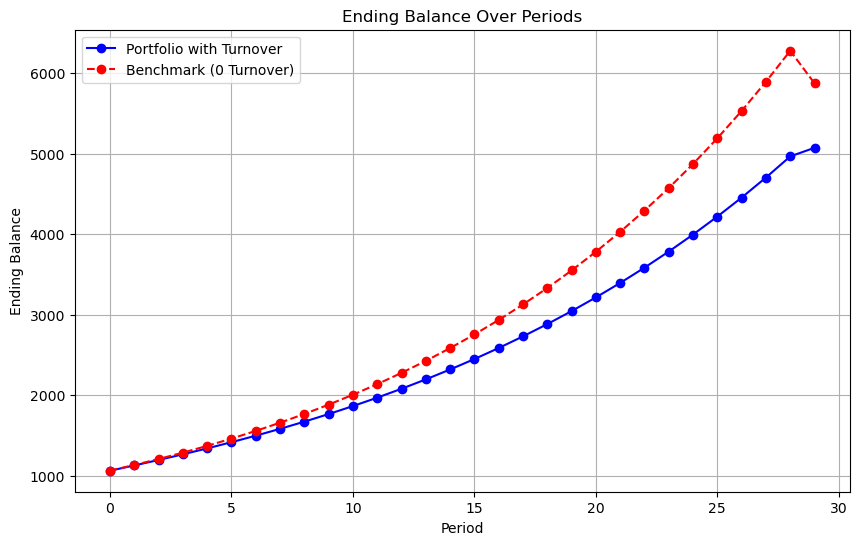

,Beginning Balance,Beginning Cost Basis,Investment Return,Dividend Income,Realized Gain/Loss,Tax Cost,Ending Cost Basis,Ending Balance,Benchmark Beg Balance (0 Turnover),Benchmark Beg Cost (0 Turnover),Benchmark Returns (0 Turnover),Benchmark Dividend Income (0 Turnover),Benchmark Realized Gain/Loss (0 Turnover),Benchmark Tax Cost (0 Turnover),Benchmark End Cost (0 Turnover),Benchmark Ending Balance (0 Turnover)
0,1000.000000,1000.000000,70.000000,23.100000,5.862500,6.041656,1022.920844,1063.958344,1000.000000,1000.000000,70.000000,23.100000,0.000000,4.620000,1018.480000,1065.380000
1,1063.958344,1022.920844,74.477084,24.577438,16.496831,8.915969,1055.079143,1129.519459,1065.380000,1018.480000,74.576600,24.610278,0.000000,4.922056,1038.168222,1135.034544
2,1129.519459,1055.079143,79.066362,26.091899,25.231887,11.337112,1095.065817,1197.248708,1135.034544,1038.168222,79.452418,26.219298,0.000000,5.243860,1059.143661,1209.243103
3,1197.248708,1095.065817,83.807410,27.656445,32.564593,13.428203,1141.858653,1267.627915,1209.243103,1059.143661,84.647017,27.933516,0.000000,5.586703,1081.490473,1288.303417
4,1267.627915,1141.858653,88.733954,29.282205,38.873784,15.283334,1194.731308,1341.078536,1288.303417,1081.490473,90.181239,29.759809,0.000000,5.951962,1105.298320,1372.532694
5,1341.078536,1194.731308,93.875497,30.978914,44.448880,16.974636,1253.184466,1417.979397,1372.532694,1105.298320,96.077289,31.705505,0.000000,6.341101,1130.662725,1462.268882
6,1417.979397,1253.184466,99.258558,32.755324,49.511637,18.557637,1316.893790,1498.680318,1462.268882,1130.662725,102.358822,33.778411,0.000000,6.755682,1157.685454,1557.872021
7,1498.680318,1316.893790,104.907622,34.619515,54.232645,20.075320,1385.670631,1583.512621,1557.872021,1157.685454,109.051042,35.986844,0.000000,7.197369,1186.474929,1659.725694
8,1583.512621,1385.670631,110.845883,36.579142,58.743840,21.561210,1459.432403,1672.797294,1659.725694,1186.474929,116.180799,38.339664,0.000000,7.667933,1217.146659,1768.238560
9,1672.797294,1459.432403,117.095811,38.641618,63.147997,23.041713,1538.180305,1766.851392,1768.238560,1217.146659,123.776699,40.846311,0.000000,8.169262,1249.823708,1883.845997


,Benchmark Ending Balance (0 Turnover),Ending Value Difference,Portfolio Annualized After Tax Performance,Benchmark Annualized After Tax Performance,Portfolio Required Breakeven Performance,Portfolio Required Annualized Alpha
Ending Balance,,,,,,
"$5,070.83","$5,869.84",$799.01,5.56%,6.08%,7.32%,1.24%


In [167]:
taxill(periods = 30, beginning_balance = 1000, beginning_cost= 1000, div_rate = 0.33, st_tax = 0.37, lt_tax = 0.20, investment_return_rate = 0.07, port_turnover = 0.25, liquidation = True)

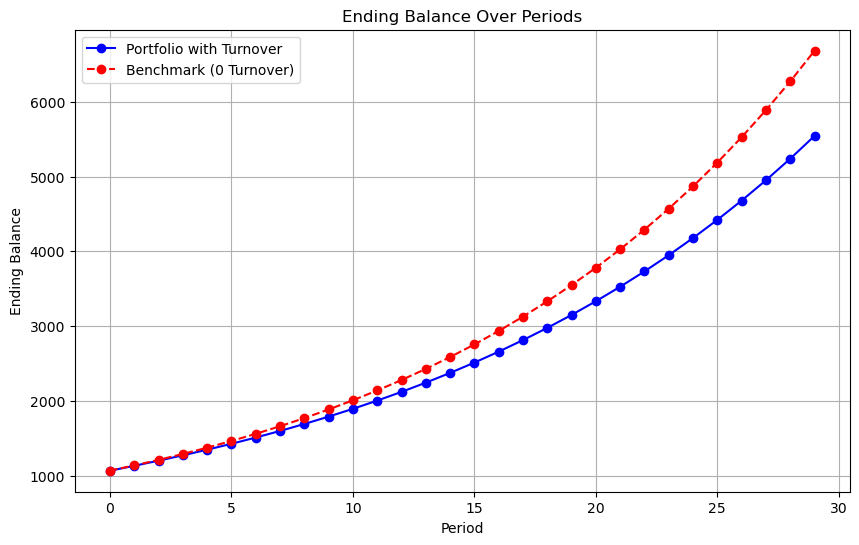

,Beginning Balance,Investment Return,Dividend Income,Beginning Cost Basis,Realized Gain/Loss,Ending Cost Basis,Tax Cost,Ending Balance,Benchmark Ending Balance (0 Turnover)
0,1000.000000,70.000000,23.100000,1000.000000,5.862500,1028.962500,6.041656,1063.958344,1065.380000
1,1063.958344,74.477084,24.577438,1028.962500,14.986417,1068.526354,8.549694,1129.885734,1135.034544
2,1129.885734,79.092001,26.100360,1068.526354,21.963800,1116.590515,10.546294,1198.431442,1209.243103
3,1198.431442,83.890201,27.683766,1116.590515,27.486036,1171.760317,12.202117,1270.119526,1288.303417
4,1270.119526,88.908367,29.339761,1171.760317,32.035878,1233.135956,13.636653,1345.391240,1372.532694
5,1345.391240,94.177387,31.078538,1233.135956,35.951177,1300.165671,14.933868,1424.634759,1462.268882
6,1424.634759,99.724433,32.909063,1300.165671,39.469193,1372.543927,16.153092,1508.206100,1557.872021
7,1508.206100,105.574427,34.839561,1372.543927,42.757401,1450.140890,17.336582,1596.443945,1659.725694
8,1596.443945,111.751076,36.877855,1450.140890,45.934916,1532.953661,18.514788,1689.680233,1768.238560
9,1689.680233,118.277616,39.031613,1532.953661,49.087393,1621.072668,19.710016,1788.247834,1883.845997


,Benchmark Ending Balance (0 Turnover),Ending Value Difference,Portfolio Annualized After Tax Performance,Benchmark Annualized After Tax Performance,Portfolio Required Breakeven Performance,Portfolio Required Annualized Alpha
Ending Balance,,,,,,
"$5,545.41","$6,685.54","$1,140.12",5.88%,6.54%,7.86%,1.32%


In [87]:
taxill(periods = 30, beginning_balance = 1000, beginning_cost= 1000, div_rate = 0.33, st_tax = 0.37, lt_tax = 0.20, investment_return_rate = 0.07, port_turnover = 0.25, liquidation = False)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Initialize variables
def taxill(periods = 30, beginning_balance = 1000, beginning_cost = 0, div_rate = 0.33, st_tax = 0.37, lt_tax = 0.20, investment_return_rate = 0.07, port_turnover = 0.25, liquidation = False):
    
    if beginning_cost is None: 
        beginning_cost = beginning_balance
    benchmark_cost = beginning_cost
    benchmark_begin_bal = beginning_balance
    
    lt_tax_adj = lt_tax * (1 - port_turnover)
    st_tax_adj = st_tax * port_turnover

    # Preallocate lists with fixed size
    beginning_balances = [0] * periods
    investment_returns = [0] * periods
    div_incs = [0] * periods
    beginning_cost_basis = [0] * periods
    realized_gls = [0] * periods
    tax_costs = [0] * periods
    ending_cost_basis = [0] * periods
    ending_balances = [0] * periods

    benchmark_ending_balances = [0] * periods  # For the benchmark with zero turnover
    benchmark_realized_gls = [0] * periods
    benchmark_tax_costs = [0] * periods
    benchmark_end_cost_basis = [0] * periods
    benchmark_investment_returns = [0] * periods
    benchmark_div_incs = [0] * periods
    benchmark_begin_bals = [0] * periods
    benchmark_cost_basis = [0] * periods
    benchmark_begin_bals = [0] * periods
    # Loop for the specified number of periods
    for i in range(periods):
        # Main portfolio calculations
        beginning_balances[i] = beginning_balance
        beginning_cost_basis[i] = beginning_cost
    
        investment_return = beginning_balance * investment_return_rate
        investment_returns[i] = investment_return
    
        div_inc = investment_return * div_rate
        div_incs[i] = div_inc
    
        realized_gl = (investment_return - div_inc) * port_turnover / 2 + (beginning_balance - beginning_cost) * port_turnover
        tax_cost = div_inc * lt_tax + realized_gl * lt_tax_adj + realized_gl * st_tax_adj
        ending_cost = beginning_cost + realized_gl + div_inc - tax_cost
        ending_balance = beginning_balance + investment_return - tax_cost
        
        if i == periods - 1:
            if liquidation == False:
                ending_balance = beginning_balance + investment_return - tax_cost
            else:
                realized_gl = (investment_return - div_inc) + (beginning_balance - beginning_cost)
                tax_cost = div_inc * lt_tax + realized_gl * lt_tax_adj + realized_gl * st_tax_adj
                ending_cost = beginning_cost + realized_gl + div_inc - tax_cost
                ending_balance = beginning_balance + investment_return - tax_cost

        realized_gls[i] = realized_gl
        tax_costs[i] = tax_cost
        ending_cost_basis[i] = ending_cost
        ending_balances[i] = ending_balance
        
        # Update for next period
        beginning_balance = ending_balance
        beginning_cost = ending_cost

        # Benchmark calculations (with zero turnover)
        benchmark_begin_bals[i] = benchmark_begin_bal
        benchmark_cost_basis[i] = benchmark_cost
        benchmark_investment_return = benchmark_begin_bal * investment_return_rate
        benchmark_investment_returns[i] = benchmark_investment_return
        benchmark_div_inc = benchmark_investment_return * div_rate
        benchmark_div_incs[i] = benchmark_div_inc
    
        # No realized gain/loss, hence no taxes on gains
        benchmark_realized_gl = 0
        benchmark_tax_cost = benchmark_div_inc * lt_tax
        benchmark_end_cost = benchmark_cost + benchmark_div_inc - (benchmark_div_inc * lt_tax)
    
        benchmark_ending_balance = benchmark_begin_bal + benchmark_investment_return - benchmark_tax_cost
        
        if i == periods - 1:
            if liquidation == False:
                benchmark_ending_balance = benchmark_begin_bal + benchmark_investment_return - benchmark_tax_cost
            else:
                benchmark_realized_gl = (benchmark_investment_return - benchmark_div_inc) + (benchmark_begin_bal - benchmark_cost)
                benchmark_tax_cost = benchmark_div_inc * lt_tax + benchmark_realized_gl * lt_tax
                benchmark_end_cost = benchmark_cost + benchmark_realized_gl + benchmark_div_inc - benchmark_tax_cost
                benchmark_ending_balance = benchmark_begin_bal + benchmark_investment_return - benchmark_tax_cost
    
        benchmark_realized_gls[i] = benchmark_realized_gl
        benchmark_tax_costs[i] = benchmark_tax_cost
        benchmark_end_cost_basis[i] = benchmark_end_cost
        benchmark_ending_balances[i] = benchmark_ending_balance
        
        # Update for next period
        benchmark_begin_bal = benchmark_ending_balance
        benchmark_cost = benchmark_end_cost

    
    # Calculate the additional information for the summary table
    end_val_dif = abs(ending_balances[-1] - benchmark_ending_balances[-1])
    pat_perf = ((ending_balances[-1] / beginning_balances[0])**(1/periods))-1
    bat_perf = ((benchmark_ending_balances[-1] / beginning_balances[0])**(1/periods))-1

    # Required Breakeven Performance Calculation
    required_return_rate = investment_return_rate
    tolerance = 1e-6  # Convergence tolerance
    max_iterations = 1000

    for _ in range(max_iterations):
        test_balance = beginning_balances[0]
        test_cost = beginning_balances[0]
    
        for i in range(periods):
            test_return = test_balance * required_return_rate
            test_div_inc = test_return * div_rate
            test_realized_gl = (test_return - test_div_inc) * port_turnover / 2 + (test_balance - test_cost) * port_turnover
            test_tax_cost = test_div_inc * lt_tax + test_realized_gl * lt_tax_adj + test_realized_gl * st_tax_adj
        
            if i == periods - 1 and liquidation:  # Adjust the last period with liquidation
                # Liquidation at the final period
                test_realized_gl = (test_return - test_div_inc) + (test_balance - test_cost)
                test_tax_cost = test_div_inc * lt_tax + test_realized_gl * lt_tax_adj + test_realized_gl * st_tax_adj
        
            test_cost += test_realized_gl + test_div_inc - (test_div_inc * lt_tax)
            test_balance += test_return - test_tax_cost

        if abs(test_balance - benchmark_ending_balances[-1]) < tolerance:
            break

    # Adjust the return rate for the next iteration
        if test_balance < benchmark_ending_balances[-1]:
            required_return_rate += 0.00001  # Increase the rate slightly
        else:
            required_return_rate -= 0.00001  # Decrease the rate slightly

    req_alpha = required_return_rate - bat_perf
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Beginning Balance': beginning_balances,
        'Beginning Cost Basis': beginning_cost_basis,
        'Investment Return': investment_returns,
        'Dividend Income': div_incs,
        'Realized Gain/Loss': realized_gls,
        'Tax Cost': tax_costs,
        'Ending Cost Basis': ending_cost_basis,
        'Ending Balance': ending_balances,
        'Benchmark Beg Balance (0 Turnover)': benchmark_begin_bals,
        'Benchmark Beg Cost (0 Turnover)': benchmark_cost_basis,
        'Benchmark Returns (0 Turnover)': benchmark_investment_returns,
        'Benchmark Dividend Income (0 Turnover)': benchmark_div_incs,
        'Benchmark Realized Gain/Loss (0 Turnover)': benchmark_realized_gls,
        'Benchmark Tax Cost (0 Turnover)': benchmark_tax_costs,
        'Benchmark End Cost (0 Turnover)': benchmark_end_cost_basis,
        'Benchmark Ending Balance (0 Turnover)': benchmark_ending_balances
    })

    df1 = pd.DataFrame({
        'Ending Balance': [ending_balances[-1]],
        'Benchmark Ending Balance (0 Turnover)': [benchmark_ending_balances[-1]],
        'Ending Value Difference': [end_val_dif],
        'Portfolio Annualized After Tax Performance': [pat_perf], 
        'Benchmark Annualized After Tax Performance': [bat_perf], 
        'Portfolio Required Breakeven Performance': [required_return_rate],
        'Portfolio Required Annualized Alpha': [req_alpha],
    })

    df1['Ending Balance'] = df1['Ending Balance'].apply(lambda x: "${:,.2f}".format(x))
    df1['Ending Value Difference'] = df1['Ending Value Difference'].apply(lambda x: "${:,.2f}".format(x))
    df1['Benchmark Ending Balance (0 Turnover)'] = df1['Benchmark Ending Balance (0 Turnover)'].apply(lambda x: "${:,.2f}".format(x))

    # Format columns as percentage
    df1['Portfolio Annualized After Tax Performance'] = df1['Portfolio Annualized After Tax Performance'].apply(lambda x: "{:.2%}".format(x))
    df1['Benchmark Annualized After Tax Performance'] = df1['Benchmark Annualized After Tax Performance'].apply(lambda x: "{:.2%}".format(x))
    df1['Portfolio Required Breakeven Performance'] = df1['Portfolio Required Breakeven Performance'].apply(lambda x: "{:.2%}".format(x))
    df1['Portfolio Required Annualized Alpha'] = df1['Portfolio Required Annualized Alpha'].apply(lambda x: "{:.2%}".format(x))
    df1.set_index("Ending Balance", inplace = True)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(df['Ending Balance'], marker='o', linestyle='-', color='b', label='Portfolio with Turnover')
    plt.plot(df['Benchmark Ending Balance (0 Turnover)'], marker='o', linestyle='--', color='r', label='Benchmark (0 Turnover)')
    plt.title('Ending Balance Over Periods')
    plt.xlabel('Period')
    plt.ylabel('Ending Balance')
    plt.grid(True)
    plt.legend()
    plt.show()
    return display(df, df1)


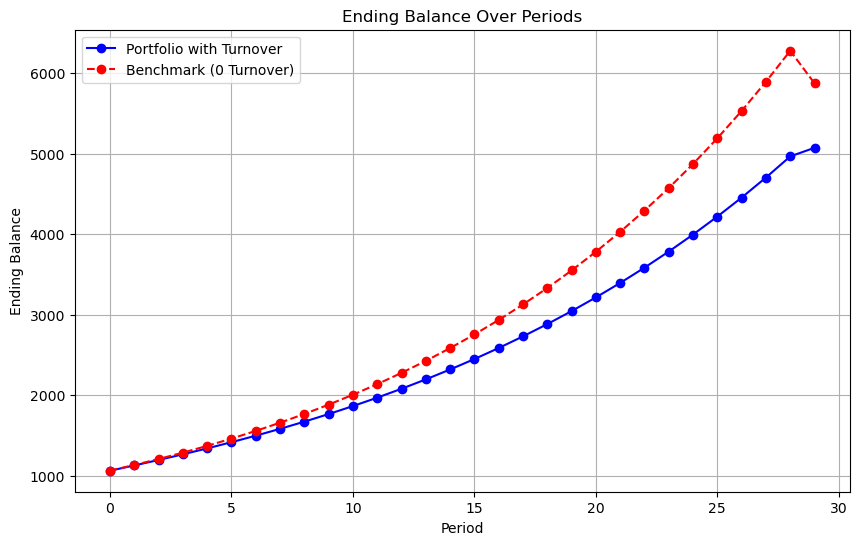

,Beginning Balance,Beginning Cost Basis,Investment Return,Dividend Income,Realized Gain/Loss,Tax Cost,Ending Cost Basis,Ending Balance,Benchmark Beg Balance (0 Turnover),Benchmark Beg Cost (0 Turnover),Benchmark Returns (0 Turnover),Benchmark Dividend Income (0 Turnover),Benchmark Realized Gain/Loss (0 Turnover),Benchmark Tax Cost (0 Turnover),Benchmark End Cost (0 Turnover),Benchmark Ending Balance (0 Turnover)
0,1000.000000,1000.000000,70.000000,23.100000,5.862500,6.041656,1022.920844,1063.958344,1000.000000,1000.000000,70.000000,23.100000,0.000000,4.620000,1018.480000,1065.380000
1,1063.958344,1022.920844,74.477084,24.577438,16.496831,8.915969,1055.079143,1129.519459,1065.380000,1018.480000,74.576600,24.610278,0.000000,4.922056,1038.168222,1135.034544
2,1129.519459,1055.079143,79.066362,26.091899,25.231887,11.337112,1095.065817,1197.248708,1135.034544,1038.168222,79.452418,26.219298,0.000000,5.243860,1059.143661,1209.243103
3,1197.248708,1095.065817,83.807410,27.656445,32.564593,13.428203,1141.858653,1267.627915,1209.243103,1059.143661,84.647017,27.933516,0.000000,5.586703,1081.490473,1288.303417
4,1267.627915,1141.858653,88.733954,29.282205,38.873784,15.283334,1194.731308,1341.078536,1288.303417,1081.490473,90.181239,29.759809,0.000000,5.951962,1105.298320,1372.532694
5,1341.078536,1194.731308,93.875497,30.978914,44.448880,16.974636,1253.184466,1417.979397,1372.532694,1105.298320,96.077289,31.705505,0.000000,6.341101,1130.662725,1462.268882
6,1417.979397,1253.184466,99.258558,32.755324,49.511637,18.557637,1316.893790,1498.680318,1462.268882,1130.662725,102.358822,33.778411,0.000000,6.755682,1157.685454,1557.872021
7,1498.680318,1316.893790,104.907622,34.619515,54.232645,20.075320,1385.670631,1583.512621,1557.872021,1157.685454,109.051042,35.986844,0.000000,7.197369,1186.474929,1659.725694
8,1583.512621,1385.670631,110.845883,36.579142,58.743840,21.561210,1459.432403,1672.797294,1659.725694,1186.474929,116.180799,38.339664,0.000000,7.667933,1217.146659,1768.238560
9,1672.797294,1459.432403,117.095811,38.641618,63.147997,23.041713,1538.180305,1766.851392,1768.238560,1217.146659,123.776699,40.846311,0.000000,8.169262,1249.823708,1883.845997


,Benchmark Ending Balance (0 Turnover),Ending Value Difference,Portfolio Annualized After Tax Performance,Benchmark Annualized After Tax Performance,Portfolio Required Breakeven Performance,Portfolio Required Annualized Alpha
Ending Balance,,,,,,
"$5,070.83","$5,869.84",$799.01,5.56%,6.08%,7.45%,1.37%


In [5]:
taxill(periods = 30, beginning_balance = 1000, beginning_cost= 1000, div_rate = 0.33, st_tax = 0.37, lt_tax = 0.20, investment_return_rate = 0.07, port_turnover = 0.25, liquidation = True)